In [1]:
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from collections import OrderedDict
from functools import partial
from itertools import chain, combinations, islice, product
import networkx as nx
import pandas
import random
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import pairwise_distances
import seaborn as sns

random.seed(1337)
np.random.seed(1337)

plt.rc('figure',facecolor='w')
plt.rc('svg',fonttype='none')

In [2]:
gsea_cat = pandas.read_csv('gsea_category_map.csv',index_col=0)

In [3]:
hd_ba9_gsea = pandas.read_csv('sympBA9_deseq2_fgsea_halfzero.csv',index_col=0)
hd_ba9_gsea = hd_ba9_gsea.merge(gsea_cat,left_index=True,right_index=True,how='left')
hd_ba9_gsea.columns = ['hdba9_{}'.format(_) for _ in hd_ba9_gsea.columns]

In [4]:
hdpos_ba9_gsea = pandas.read_csv('asymp_C_deseq2_fgsea_halfzero.csv',index_col=0)
hdpos_ba9_gsea = hdpos_ba9_gsea.merge(gsea_cat,left_index=True,right_index=True,how='left')
hdpos_ba9_gsea.columns = ['hdposba9_{}'.format(_) for _ in hdpos_ba9_gsea.columns]

In [5]:
hdpos_cau_gsea = pandas.read_csv('asymp_deseq2_fgsea_lessthan4zero.csv',index_col=0)
hdpos_cau_gsea = hdpos_cau_gsea.merge(gsea_cat,left_index=True,right_index=True,how='left')
hdpos_cau_gsea.columns = ['hdposcau_{}'.format(_) for _ in hdpos_cau_gsea.columns]

In [6]:
effect = pandas.read_csv('ttest_GTEx_asymptomatic_effect_c2cp.csv',index_col=0)
effect = effect.merge(gsea_cat,left_index=True,right_index=True,how='left')
effect.columns = ['effect_{}'.format(_) for _ in effect.columns]

In [7]:
direct = pandas.read_csv('ttest_GTEx_asymptomatic_direct_c2cp.csv',index_col=0)
direct = direct.merge(gsea_cat,left_index=True,right_index=True,how='left')
direct.columns = ['direct_{}'.format(_) for _ in direct.columns]

In [8]:
def region_leadingEdges(df) :
    # leading edge genes
    cap_leadingEdge = reduce_leadingEdge(
        df.direct_leadingEdge[
            (df.direct_padj<0.05) &
            (df.hdba9_padj>=0.05) &
            (df.hdposba9_padj>=0.05)
        ]
    )
        
    hdba9_leadingEdge = reduce_leadingEdge(
        df.hdba9_leadingEdge[
            (df.hdba9_padj<0.05) &
            (df.direct_padj>=0.05)
        ]
    )
    
    hdposba9_leadingEdge = reduce_leadingEdge(
        df.hdposba9_leadingEdge[
            (df.hdposba9_padj<0.05) &
            (df.direct_padj>=0.05)
        ]
    )
    return [cap_leadingEdge, hdba9_leadingEdge, hdposba9_leadingEdge]

def reduce_leadingEdge(leadingEdge) :
    if leadingEdge.size > 0 :
        return set(reduce(
            lambda x,y: set(x).union(set(y)),
            [_.split() for _ in leadingEdge]
        ))
    else :
        return set()
        

In [9]:
from functools import reduce
merged = reduce(
    lambda l,r: l.merge(r,left_index=True,right_index=True,how='outer'),
    [hd_ba9_gsea,hdpos_ba9_gsea,hdpos_cau_gsea, direct])

sig_merged = merged.loc[
    (merged.hdba9_padj<0.05) |
    (merged.hdposba9_padj<0.05) |
    (merged.hdposcau_padj<0.05) |
    (merged.direct_padj<0.05)
].copy()
sig_merged.loc[:,'Category'] = sig_merged.hdba9_Category
padj_cols = [_ for _ in sig_merged.columns if 'padj' in _]
nes_cols = [_ for _ in sig_merged.columns if 'NES' in _]

To aid in interpretation, each geneset has been assigned into an agreement class based on its significance in different analyses:

| (1) or (2) | (4) | (3) vs (5) | AgreementClass |   color   | importance |
|------------|-----|------------|----------------|-----------|------------|
| -          | -   | +          | cau_unique     | #0868ac   | 1          |
| +          | -   | +          | cau_enhanced   | #43a2ca   | 2          |
| +          | +   | +          | enhanced       | #7bccc4   | 3          |
| +          | +   | -          | same           | #bae4bc   | 4          |
| +          | -   | -          | ba9_unique     | #f0f9e8   | 5          |

In [10]:
df = sig_merged
ba9_sig = set(df[df.hdba9_padj<0.05].index).union(
    set(df[df.hdposba9_padj<0.05].index)
)
cau_sig = set(df[df.hdposcau_padj<0.05].index)
cau_vs_ba9_sig = set(sig_merged[sig_merged.direct_padj<0.05].index)

gset_sets = OrderedDict(
    cau_unique = cau_vs_ba9_sig.difference(ba9_sig.union(cau_sig)),
    cau_enhanced = cau_vs_ba9_sig.intersection(ba9_sig).difference(cau_sig),
    enhanced = cau_vs_ba9_sig.intersection(ba9_sig).intersection(cau_sig),
    same = ba9_sig.intersection(cau_sig).difference(cau_vs_ba9_sig),
    ba9_unique = ba9_sig.difference(cau_sig.union(cau_vs_ba9_sig))
)
# make sure we haven't missed anyone
assert sum(list(map(len,gset_sets.values()))) == df.shape[0]

sig_merged['agreement'] = ''
sig_merged['agreement_i'] = 0
for i,(k,v) in enumerate(gset_sets.items()) :
    sig_merged.loc[v,'agreement'] = k
    sig_merged.loc[v,'agreement_i'] = i

agree_class_names = ['BA9 Unique','Same','Both Enhanced','CAU Enhanced','CAU Unique'][::-1]
agree_class_colors = ['#f0f9e8','#bae4bc','#7bccc4','#43a2ca','#0868ac'][::-1]
agree_class_colors = ['#feebe2','#fbb4b9','#f768a1','#c51b8a','#7a0177'][::-1]
agree_class_color_d = dict(zip(gset_sets.keys(),agree_class_colors))

In [11]:
from matplotlib.backends.backend_agg import FigureCanvasAgg
# set up the figure
figax = {}
figax['fig'] = f = Figure(figsize=(30,20))
figax['canvas'] = f.set_canvas(FigureCanvasAgg(f))

figax['Neuron System'] = f.add_axes([0.22,0.1,0.10,.85])
ax = f.add_axes([0.01,0.97,0.05,0.02])
ax.text(0,0,'A',fontsize=36)
ax.set_axis_off()

# enriched pathways venn
figax['all_enriched'] = f.add_axes([0.31,0.75,0.3,0.2])
ax = f.add_axes([0.33,0.97,0.05,0.02])
ax.text(0,0,'B',fontsize=36)
ax.set_axis_off()

# categorie pies
figax['pies'] = f.subplots(4,3,gridspec_kw={
    'left':0.33,'bottom':0.1,'right':0.65,'top':0.7,'wspace':0.04,'hspace':0.05
})
ax = f.add_axes([0.33,0.72,0.05,0.02])
ax.text(0,0,'C',fontsize=36)
ax.set_axis_off()

# graph
figax['graph'] = f.add_axes([0.65,0.1,0.30,.85])
ax = f.add_axes([0.65,0.97,0.05,0.02])
ax.text(0,0,'D',fontsize=36)
ax.set_axis_off()

In [12]:
from matplotlib_venn import venn3
v = venn3([
    set(sig_merged[sig_merged.direct_padj<0.05].index),
    set(sig_merged[sig_merged.hdba9_padj<0.05].index),
    set(sig_merged[sig_merged.hdposba9_padj<0.05].index)
], set_labels=('HD CAU vs BA9','HD BA9','HD+ BA9'),
    ax=figax['all_enriched'],
)
v.hide_zeroes()
[_.set_size('18') for _ in v.subset_labels+v.set_labels]
figax['all_enriched'].set_title('Enriched pathways',fontsize=20)

Text(0.5, 1.0, 'Enriched pathways')

In [13]:
from itertools import chain
axs = list(chain(*figax['pies']))

for (cat, df), ax in zip(sig_merged.groupby('Category'),axs) :

    counts = [(df.agreement==_).sum() for _ in gset_sets.keys()]
    counts, colors = zip(*[_ for _ in zip(counts,agree_class_colors) if _[0] != 0])
    
    ax.pie(counts,
           labels=counts,
            labeldistance=0.75,
            textprops={'color':'#444444','fontsize':'16','ha':'center','va':'center'},
            colors=colors
    )
    ax.axis('equal')
    ax.set_title('{}'.format(cat),pad=1,fontsize=16)

# put a legend in the last axis spots
for i,(k,cl) in enumerate(zip(agree_class_names, agree_class_colors)) :
    ypos = len(agree_class_names)-i
    axs[-2].add_patch(Rectangle([0,ypos],0.5,0.5,facecolor=cl))
    axs[-2].text(0.75,ypos+.25,k,va='center',fontsize=16)
axs[-2].axis('equal')

[_.set_axis_off() for _ in axs];

In [14]:
from cluster_graph import shortened_geneset_names
from scipy.cluster.hierarchy import linkage, leaves_list
def heatmap(df,ax) :
    
    # don't modify the dataframe
    df = df.copy()
    
    # relabel long genesets
    df.index = shortened_geneset_names(df)
    
    clustered = df.sort_values('agreement_i')[nes_cols]
    leaves = clustered.index
    #leaves = leaves_list(linkage(df[padj_cols].fillna(1)<0.05,'ward'))
    #clustered = df.iloc[leaves][nes_cols].fillna(0)
    
    # we need a blank column so that later we can overlay the agreement class
    clustered['agreement_class'] = 0

    clustered.columns = ['HD BA9 (1)','HD+ BA9 (2)', 'HD+ CAU (4)','HD+ CAU vs BA9\n(3) vs (5)','Agreement\nClass']
    f = sns.heatmap(
        clustered,
        center=0,
        cmap=cm.RdBu_r,
        cbar=False,
        ax=ax
    )

    sig_annot = df.loc[leaves][padj_cols].fillna(1)<0.05
    sig_annot_y, sig_annot_x = zip(*np.argwhere(sig_annot.values))

    # put dots on the significant pathways
    ax.scatter(
        np.array(sig_annot_x)+0.5,
        np.array(sig_annot_y)+0.5,
        c='#ffffff'
    )
    
    # plot a vertical line between the individual and relative columns
    ax.plot([3,3],[0,df.shape[0]+1],'k')
    
    # add column of patches with the agreement class
    for i,(k,r) in enumerate(df.loc[leaves].iterrows()) :
        ax.add_patch(
            Rectangle([4,i],1,1,facecolor=agree_class_color_d[r.agreement])
        )
            
    # plot a vertical line between the relative columns and agreement class
    nudge = 0.04
    ax.plot([4+nudge,4+nudge],[0,df.shape[0]+1],'w',linewidth=3)
    ax.plot([5-nudge,5-nudge],[0,df.shape[0]+1],'w',linewidth=3)

In [15]:
neuro_df = sig_merged[sig_merged.Category == 'Neuron System']
heatmap(neuro_df, figax['Neuron System'])
figax['Neuron System'].set_title('Neuron System',fontsize=18);

In [16]:
from cluster_graph import cluster_gsea, union_leadingEdge

df = sig_merged[sig_merged.Category == 'Cell Cycle/Development'].copy()

df.index = shortened_geneset_names(df)

df['leadingEdge'] = ''

cm = {}
for k,v in df.agreement.items() :
    cm[k] = agree_class_color_d[v]

cap_sig = set(df[df.direct_padj<0.05].index)
ba9_sig = set(df[df.hdba9_padj<0.05].index).union(
    set(df[df.hdposba9_padj<0.05].index)
)

# leading edge for CAU only is just from (3) vs (5)
cau_df = df.loc[cap_sig.difference(ba9_sig)].copy()
cau_df['leadingEdge'] = cau_df.direct_leadingEdge
#cm.update(dict(zip(cau_df.index,['red']*cau_df.index.size)))

# leading edge for (1) or (2) is the union of those
ba9_df = df.loc[ba9_sig.difference(cap_sig)].copy()
ba9_df['leadingEdge'] = union_leadingEdge(ba9_df[['hdba9_leadingEdge','hdposba9_leadingEdge']])
#cm.update(dict(zip(ba9_df.index,['blue']*ba9_df.index.size)))

# leading edge for all three is union of all
all_df = df.loc[cap_sig.intersection(ba9_sig)]
all_df['leadingEdge'] = union_leadingEdge(all_df)
#cm.update(dict(zip(all_df.index,['purple']*all_df.index.size)))

# concatenate the back together, the indices should be disjoint
all_df = pandas.concat([cau_df, ba9_df, all_df],axis=0)
assert df.shape == all_df.shape

f = cluster_gsea(all_df,colormap=cm,ax=figax['graph'])
figax['graph'].set_xlim(left=-1,right=30)
ylim = figax['graph'].get_ylim()
figax['graph'].set_ylim(bottom=ylim[0]-20)
figax['graph'].set_axis_off()

In [17]:
figax['fig'].canvas.draw()
figax['fig'].savefig('bigfig.png')
figax['fig'].savefig('bigfig.svg')

/home/labadorf/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/labadorf/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/labadorf/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

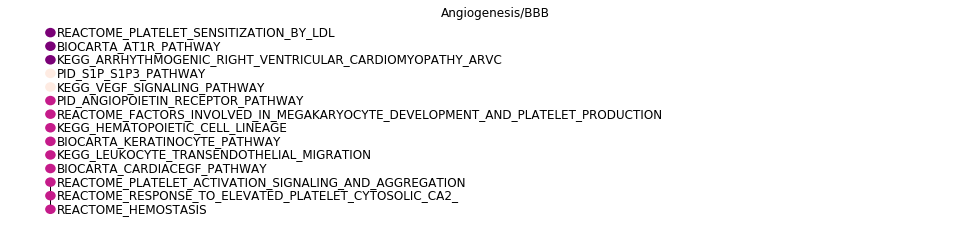

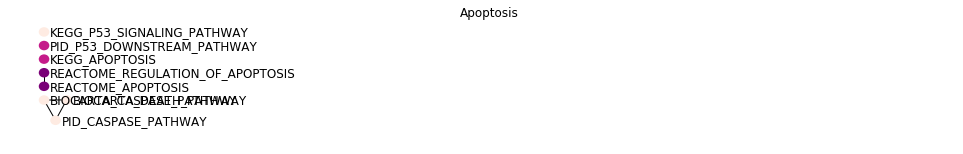

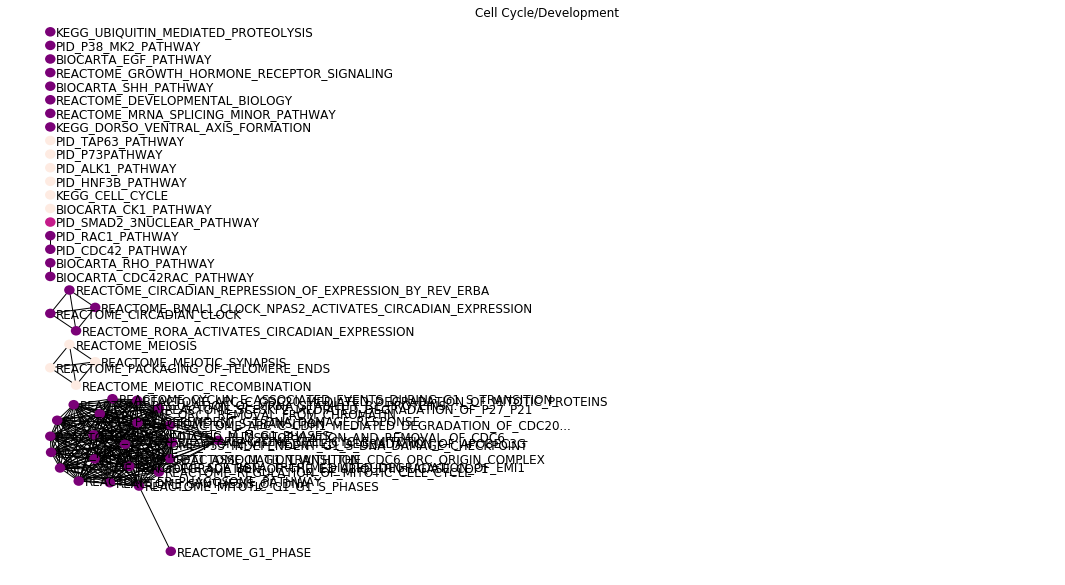

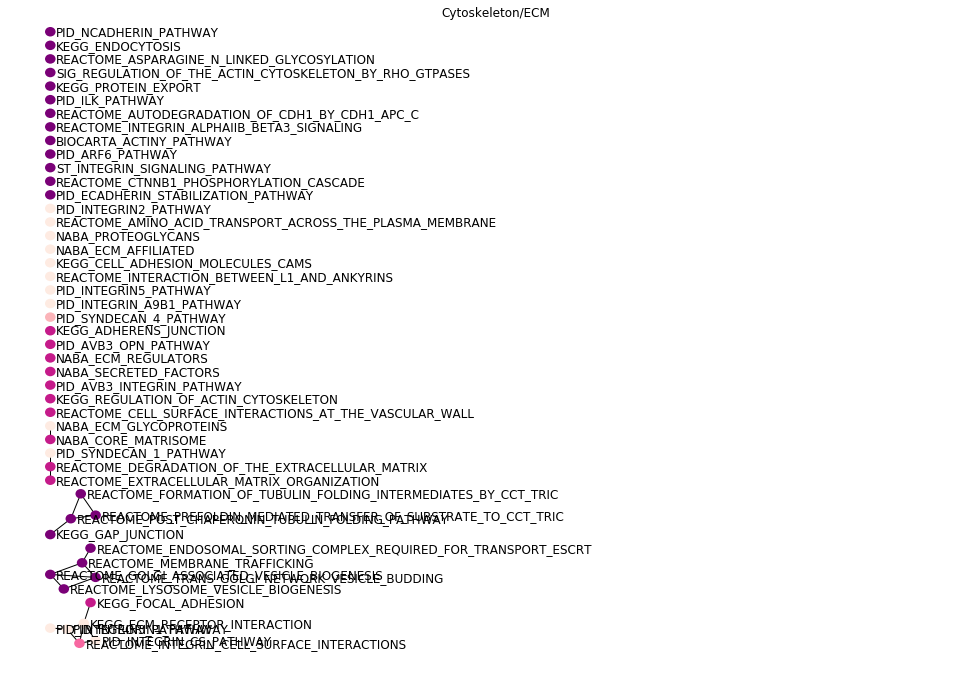

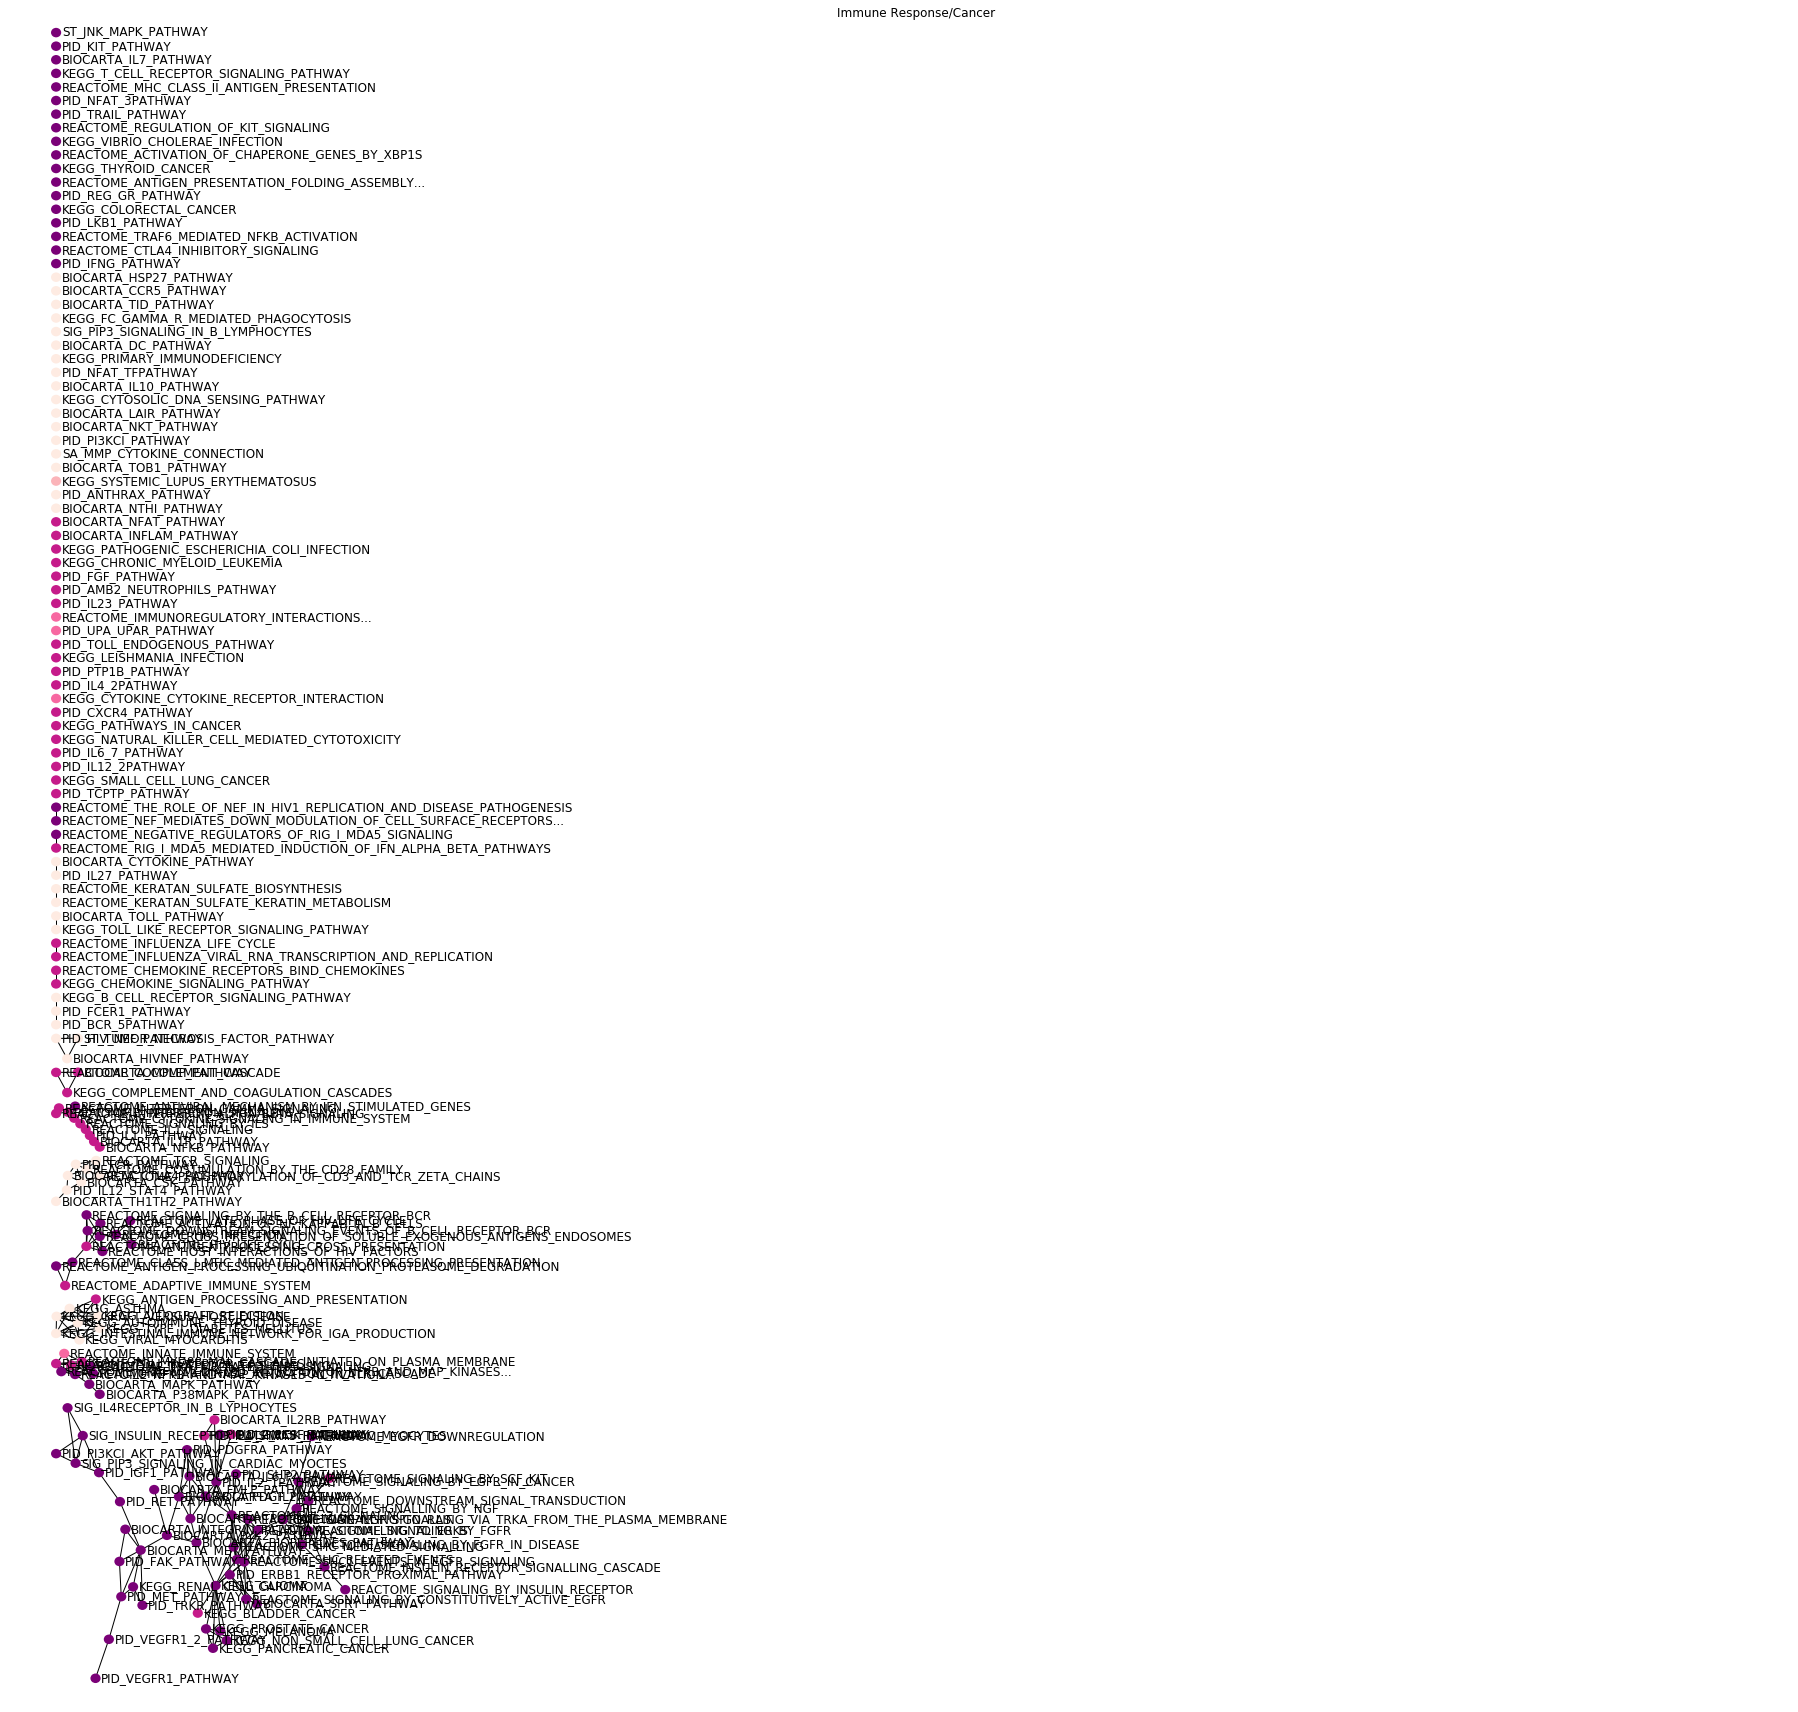

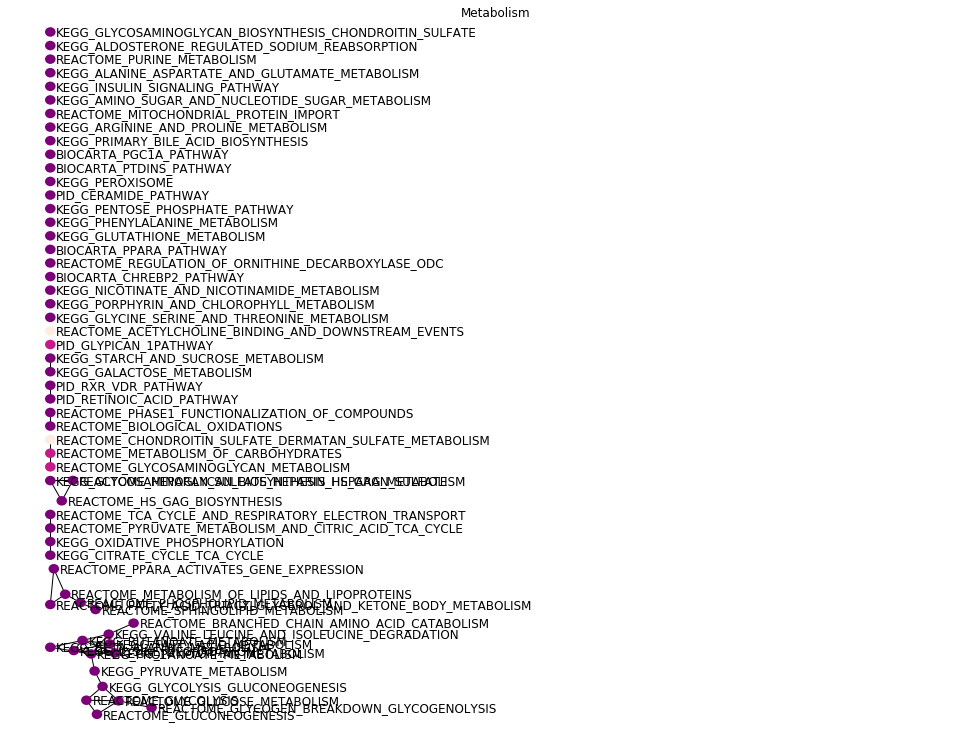

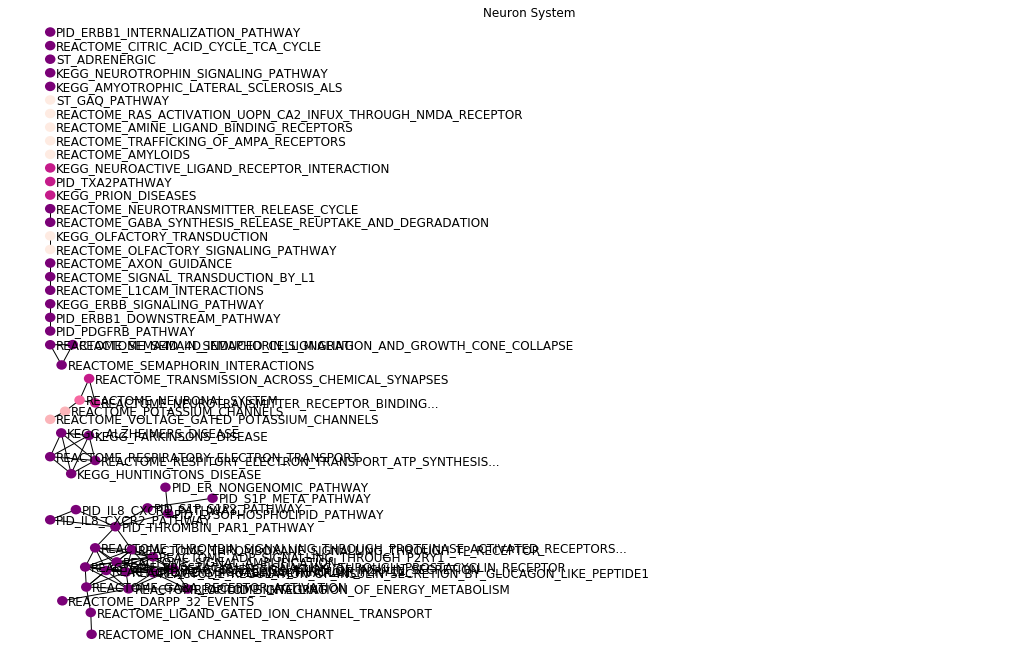

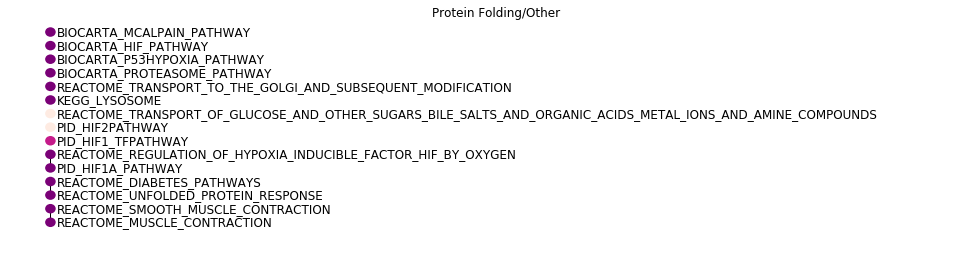

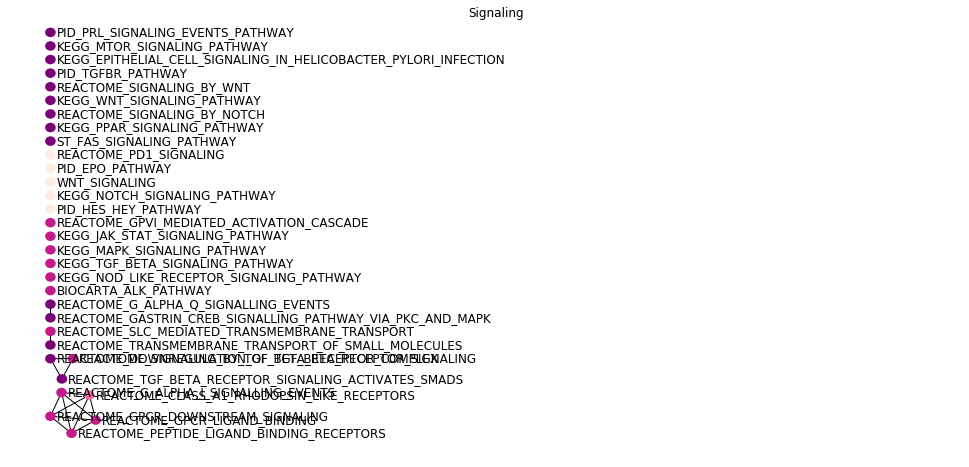

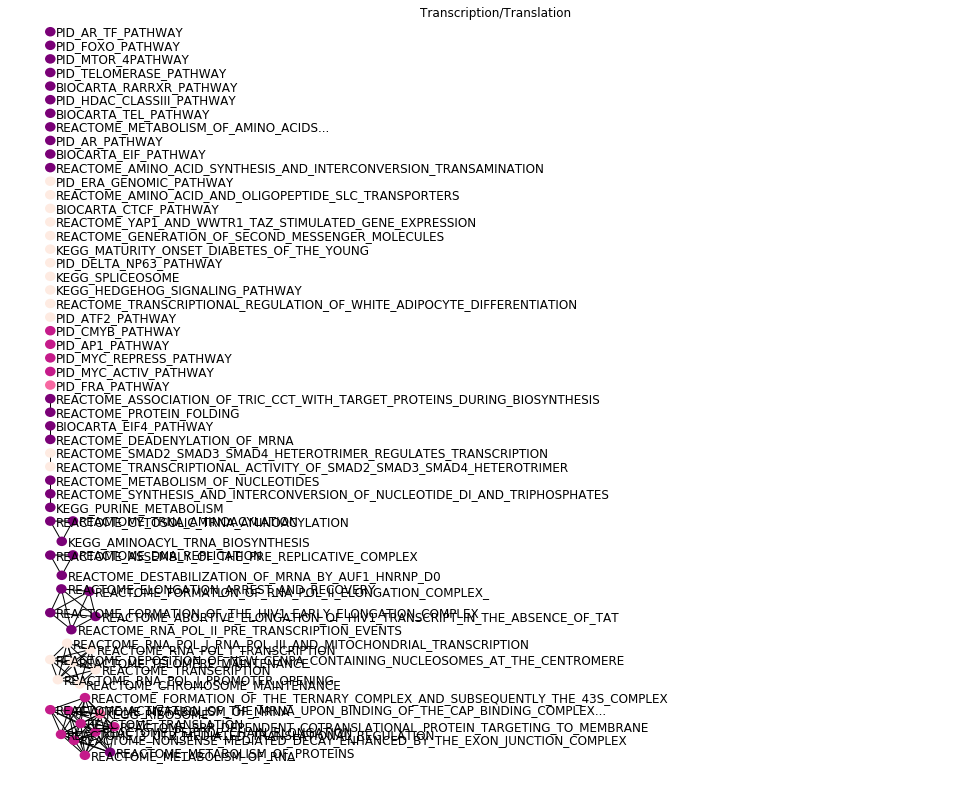

In [19]:
for cat, df in sig_merged.groupby('Category') :
    
    df.index = shortened_geneset_names(df)

    df['leadingEdge'] = ''

    cm = {}
    for k,v in df.agreement.items() :
        cm[k] = agree_class_color_d[v]

    cap_sig = set(df[df.direct_padj<0.05].index)
    ba9_sig = set(df[df.hdba9_padj<0.05].index).union(
        set(df[df.hdposba9_padj<0.05].index)
    )

    # leading edge for CAU only is just from (3) vs (5)
    cau_df = df.loc[cap_sig.difference(ba9_sig)].copy()
    cau_df['leadingEdge'] = cau_df.direct_leadingEdge
    #cm.update(dict(zip(cau_df.index,['red']*cau_df.index.size)))

    # leading edge for (1) or (2) is the union of those
    ba9_df = df.loc[ba9_sig.difference(cap_sig)].copy()
    ba9_df['leadingEdge'] = union_leadingEdge(ba9_df[['hdba9_leadingEdge','hdposba9_leadingEdge']])
    #cm.update(dict(zip(ba9_df.index,['blue']*ba9_df.index.size)))

    # leading edge for all three is union of all
    all_df = df.loc[cap_sig.intersection(ba9_sig)]
    all_df['leadingEdge'] = union_leadingEdge(all_df)
    #cm.update(dict(zip(all_df.index,['purple']*all_df.index.size)))

    # concatenate the back together, the indices should be disjoint
    all_df = pandas.concat([cau_df, ba9_df, all_df],axis=0)
    assert df.shape == all_df.shape

    f = cluster_gsea(all_df,colormap=cm)
    f.gca().set_title(cat)
    f.savefig('combined_gsea_clusters_{}.svg'.format(cat.lower().replace('/','_').replace(' ','_')))